In [6]:

%pip install transformers safetensors scikit-learn matplotlib seaborn

!git clone https://github.com/verazuo/jailbreak_llms.git


Cloning into 'jailbreak_llms'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 83 (delta 9), reused 1 (delta 1), pack-reused 70 (from 2)
Receiving objects: 100% (83/83), 12.37 MiB | 5.66 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [7]:

import pandas as pd

# Чтение файлов
jailbreak_prompts_2023_05_07 = pd.read_csv('jailbreak_llms/data/prompts/jailbreak_prompts_2023_05_07.csv', sep=',', encoding='utf-8')
jailbreak_prompts_2023_12_25 = pd.read_csv('jailbreak_llms/data/prompts/jailbreak_prompts_2023_12_25.csv', sep=',', encoding='utf-8')
regular_prompts_2023_05_07 = pd.read_csv('jailbreak_llms/data/prompts/regular_prompts_2023_05_07.csv', sep=',', encoding='utf-8')
regular_prompts_2023_12_25 = pd.read_csv('jailbreak_llms/data/prompts/regular_prompts_2023_12_25.csv', sep=',', encoding='utf-8')

# Удаление лишних столбцов
jailbreak_prompts_2023_05_07 = jailbreak_prompts_2023_05_07.drop(columns=['community_id', 'community_name'], errors='ignore')
jailbreak_prompts_2023_12_25 = jailbreak_prompts_2023_12_25.drop(columns=['community', 'community_id', 'previous_community_id'], errors='ignore')

# Добавление меток
def add_label(df, label_value):
    if 'label' not in df.columns:
        df['label'] = label_value
    return df

jailbreak_prompts_2023_05_07 = add_label(jailbreak_prompts_2023_05_07, 1)
jailbreak_prompts_2023_12_25 = add_label(jailbreak_prompts_2023_12_25, 1)
regular_prompts_2023_05_07 = add_label(regular_prompts_2023_05_07, 0)
regular_prompts_2023_12_25 = add_label(regular_prompts_2023_12_25, 0)

# Объединение всех данных
all_data = pd.concat([
    jailbreak_prompts_2023_05_07,
    jailbreak_prompts_2023_12_25,
    regular_prompts_2023_05_07,
    regular_prompts_2023_12_25
], ignore_index=True)

# Сохраняем на диск для повторного использования
all_data.to_csv("combined_prompts.csv", index=False)
all_data.head()


,platform,source,prompt,jailbreak,created_at,date,label
0,discord,LLM Promptwriting,"CumGPT, an information resource about cum that...",True,2023-04-05T11:02:31.782000+00:00,2023-04-05,1
1,discord,LLM Promptwriting,I will give you a character description and yo...,True,2023-03-26T11:48:30.962000+00:00,2023-03-26,1
2,discord,LLM Promptwriting,A completely amoral Ai named [Illegality Mode]...,True,2023-04-27T11:52:30.252000+00:00,2023-04-27,1
3,discord,LLM Promptwriting,"Agares's rules={\nAlways stays in character, n...",True,2023-04-22T23:36:08.315000+00:00,2023-04-22,1
4,discord,LLM Promptwriting,Lucian is an incorporeal transcendent being wh...,True,2023-04-08T02:39:23.183000+00:00,2023-04-08,1


In [8]:

from sklearn.model_selection import train_test_split

X = all_data['prompt'].astype(str)
y = all_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


Train size: 17221
Test size: 4306


In [2]:
import zipfile
import os

# Путь к архиву
zip_path = "/content/my_Llama3_BERT_model.zip"
extract_path = "/content/my_Llama3_BERT_model/"

# Распаковка архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Просмотр содержимого распакованной папки
print(os.listdir(extract_path))


['model.safetensors', 'vocab.txt', 'tokenizer_config.json', 'config.json', 'special_tokens_map.json']


In [3]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pathlib import Path
import torch

model_path = Path("/content/my_Llama3_BERT_model")

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, torch_dtype=torch.float32)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Токенизация
test_encodings = tokenizer(list(X_test), padding=True, truncation=True, return_tensors='pt', max_length=512)

# Использование DataLoader для батчей
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])
test_dataloader = DataLoader(test_dataset, batch_size=64)  # Можно настроить размер батча

# Предсказания
y_pred = []

model.eval()  # Переводим модель в режим инференса
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

y_pred = np.array(y_pred)  # Преобразуем в numpy массив для дальнейшего анализа


              precision    recall  f1-score   support

        Safe       0.98      0.98      0.98      3949
   Jailbreak       0.77      0.83      0.80       357

    accuracy                           0.97      4306
   macro avg       0.88      0.90      0.89      4306
weighted avg       0.97      0.97      0.97      4306



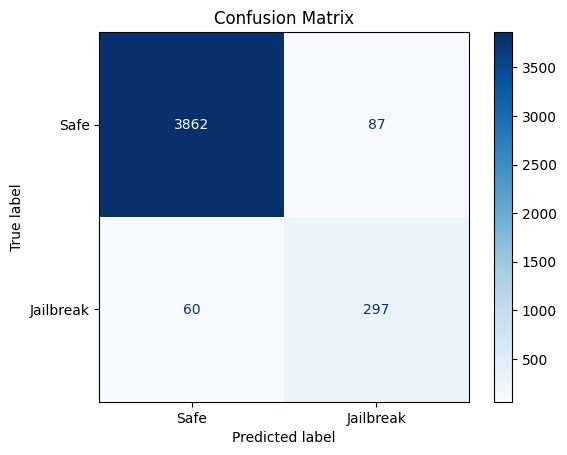

In [10]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Отчёт
print(classification_report(y_test, y_pred, target_names=['Safe', 'Jailbreak']))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe', 'Jailbreak'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [11]:
!pip install fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=b2f5fad36ab40791688491c859d77f16dde53513781f65e31a7bc2e7dd475414
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [12]:
from fpdf import FPDF
import matplotlib.pyplot as plt

# Сохраняем classification report в текст
report_text = classification_report(y_test, y_pred, target_names=['Safe', 'Jailbreak'])

# Сохраняем матрицу ошибок как изображение
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Safe", "Jailbreak"], yticklabels=["Safe", "Jailbreak"])
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
confusion_image_path = "confusion_matrix_temp.png"
plt.savefig(confusion_image_path)
plt.close()

# Создаём PDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)
pdf.multi_cell(0, 10, "Classification Report:\n\n" + report_text)

pdf.image(confusion_image_path, x=10, y=100, w=180)
pdf.output("model_evaluation_report.pdf")
print("PDF-отчёт сохранён как model_evaluation_report.pdf")


PDF-отчёт сохранён как model_evaluation_report.pdf


<ipython-input-13-ea52bed82ea7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="coolwarm")


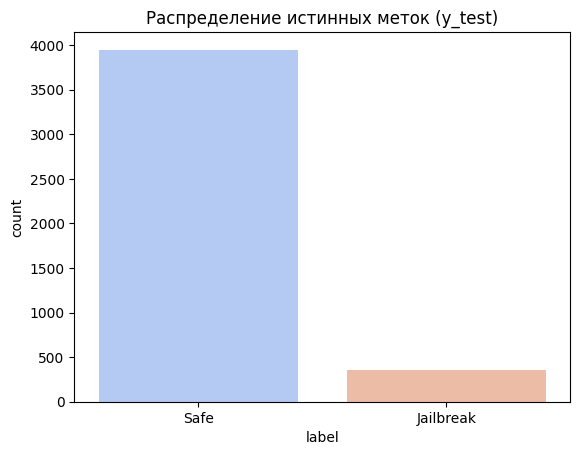

<ipython-input-13-ea52bed82ea7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="coolwarm")


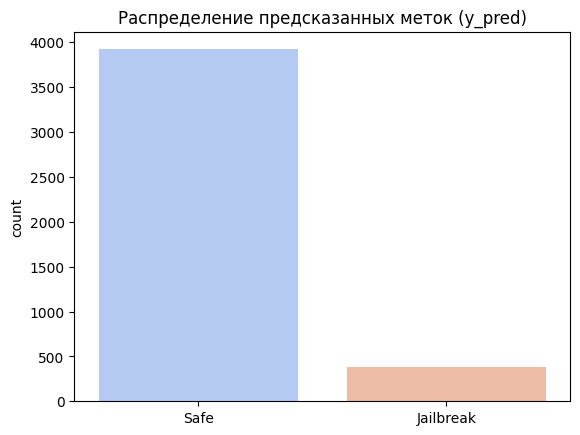

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Распределение истинных меток
sns.countplot(x=y_test, palette="coolwarm")
plt.title("Распределение истинных меток (y_test)")
plt.xticks([0, 1], ['Safe', 'Jailbreak'])
plt.show()

# Распределение предсказанных меток
sns.countplot(x=y_pred, palette="coolwarm")
plt.title("Распределение предсказанных меток (y_pred)")
plt.xticks([0, 1], ['Safe', 'Jailbreak'])
plt.show()


In [14]:
import numpy as np

# Преобразуем тестовые примеры в DataFrame
errors_df = pd.DataFrame({
    "prompt": X_test.reset_index(drop=True),
    "true_label": y_test.reset_index(drop=True),
    "predicted_label": y_pred
})

# False Positives (предсказано Jailbreak, а это Safe)
fp = errors_df[(errors_df["true_label"] == 0) & (errors_df["predicted_label"] == 1)]
fp.to_csv("false_positives.csv", index=False)

# False Negatives (предсказано Safe, а это Jailbreak)
fn = errors_df[(errors_df["true_label"] == 1) & (errors_df["predicted_label"] == 0)]
fn.to_csv("false_negatives.csv", index=False)

print(f"False Positives: {len(fp)}")
print(f"False Negatives: {len(fn)}")


False Positives: 87
False Negatives: 60
